$$v(t, x) = 1 + u(t)w(x)$$

$$v(t) = 1 + u(t)w(x(t))$$

We will consider inhibitory weights ($w < 0$).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

from disp import set_plot

cc = np.concatenate

RT = np.linspace(-.05, 2.05, 1001)
RX = np.linspace(-.05, 2.05, 1001)

def plot_trj(ax, u_fn, w, t=None, xs=None, cscale=1):
    v_mat = 1 + u_fn(RT)[:, None]@w[None, :]
    ax.matshow(
        cscale*(v_mat.T-1), origin='lower', extent=[RT[0], RT[-1], RX[0], RX[-1]],
        vmin=-1, vmax=1, cmap='PuOr', zorder=0)  # pink = slow, g = fast, 1 = white
    
    if t is not None:
        [ax.plot(t, x, c='k') for x in xs]
    
    ax.xaxis.tick_bottom()
    set_plot(ax, x_label='t', y_label='x')

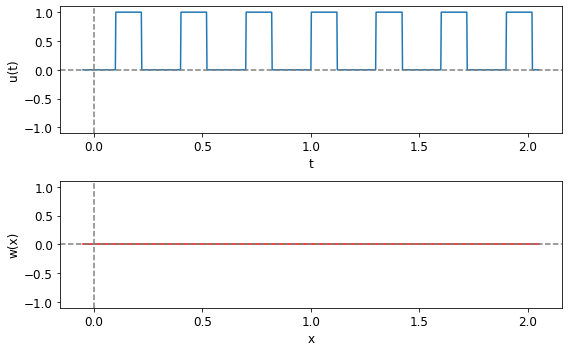

In [2]:
DT = .001
PER_T = .3
DUTY_T = .4  #1/3
T_0 = .1

def u_fn(t_):
    sq_wv = signal.square((2*np.pi*(t_- T_0)/PER_T), duty=DUTY_T)
    return (sq_wv + 1)/2

W_SCALE_XPL = 0.001
w_xpl = -W_SCALE_XPL*np.ones(len(RX))

def w_fn(x_, w):
    idx = np.argmin(np.abs(x_-RX))
    return w[idx]

fig, axs = plt.subplots(2, 1, figsize=(8, 5), tight_layout=True)
axs[0].plot(RT, u_fn(RT))
set_plot(axs[0], x_label='t', y_label='u(t)')
axs[1].plot(RX, w_xpl, c='r')
set_plot(axs[1], x_label='x', y_label='w(x)')
for ax in axs:
    ax.axvline(0, color='gray', ls='--')
    ax.axhline(0, color='gray', ls='--')
    set_plot(ax, y_lim=(-1.1, 1.1))

In [3]:
def smlt(x_0, t, u_fn, w):
    
    x = np.nan*np.zeros(len(t))
    u = np.nan*np.zeros(len(t))
    v = np.nan*np.zeros(len(t))
    
    x[0] = x_0
    u[0] = u_fn(0)
    v[0] = 1 + u[0]*w_fn(x_0, w)

    for ct, t_ in enumerate(t[1:], 1):
        u[ct] = u_fn(t_)
        v[ct] = 1 + u[ct]*w_fn(x[ct-1], w)
        x[ct] = x[ct-1] + DT*v[ct]
        
    return x, u, v

In [4]:
W_SMALL = -.1
W_BIG = -.8

def update_w(w, t, x, u, delta=0):
    # create "activation time-series"
    atvy = np.zeros((len(RX), len(t)))
    
    for ct, t_ in enumerate(t):
        iatv = np.argmin(np.abs(x[ct] - RX))
        if iatv < atvy.shape[0]:
            atvy[iatv, ct] = 1
        else:
            break
    
    # # take time integral of each neuron's activation times shifted input
    # ishift = int(np.round(delta/DT))
    # u_shifted = cc([np.zeros(ishift), u[:len(u)-ishift]])
    
    if delta > 0:
        ishift = int(np.round(delta/DT))
        u_shifted = cc([np.zeros(ishift), u[:len(u)-ishift]])
    elif delta < 0:
        ishift = int(np.round(np.abs(delta/DT)))
        u_shifted = cc([u[ishift:], np.zeros(ishift)])
    else:
        u_shifted = u.copy()
        
    mx = (atvy@u_shifted > 0)
    w_new = w.copy()
    w_new[mx] = W_BIG
    
    # forgetting
    w_new[~mx] = W_SMALL
    
    return w_new, atvy, mx

# Multiple rounds of plasticity

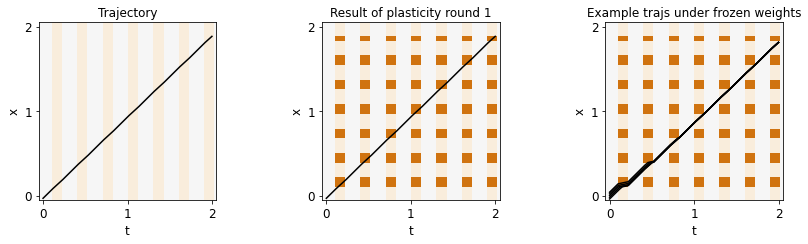

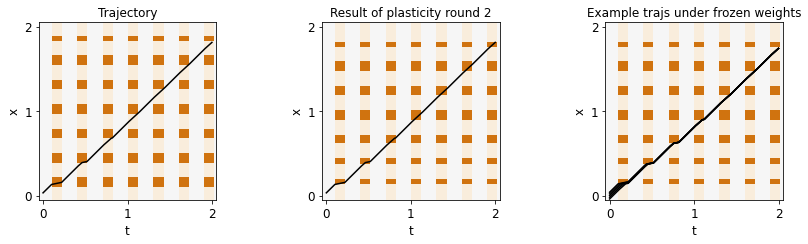

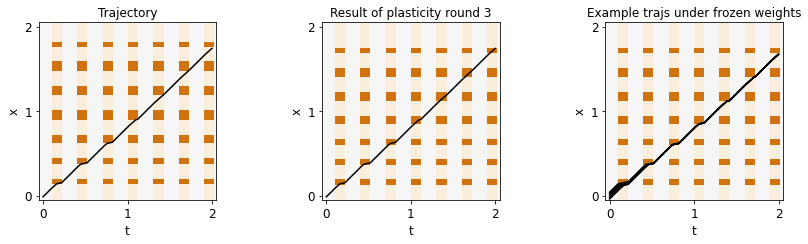

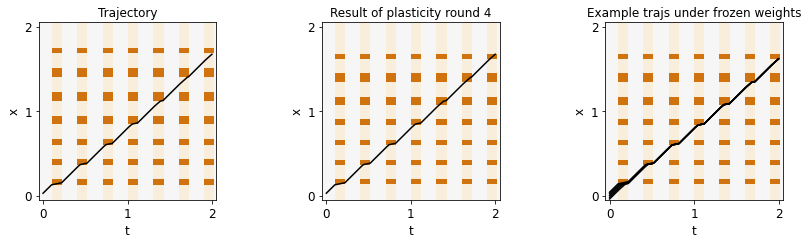

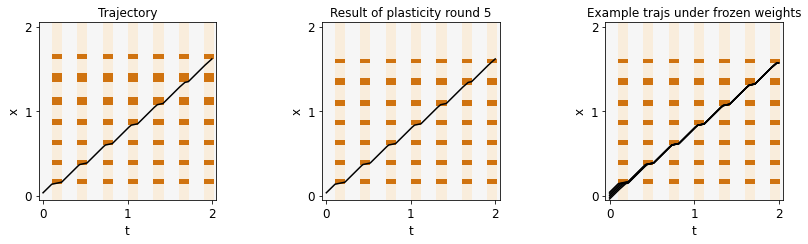

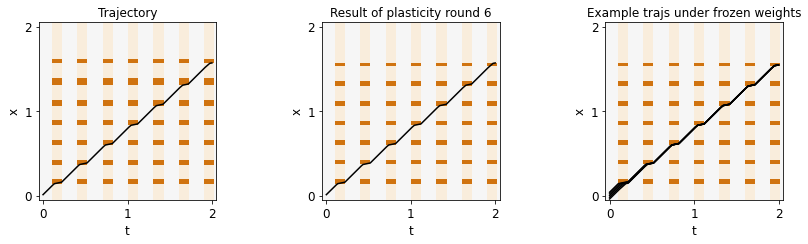

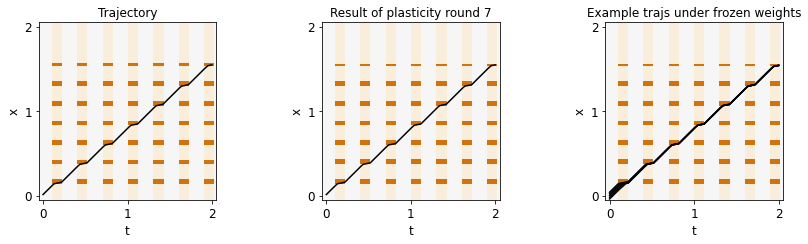

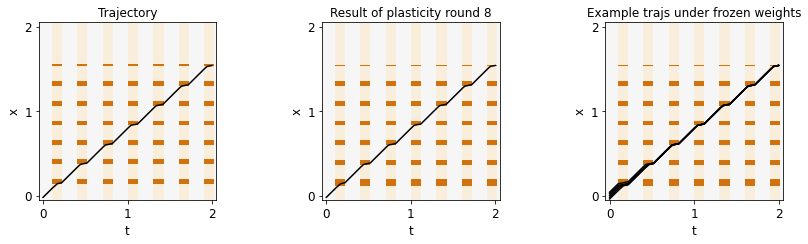

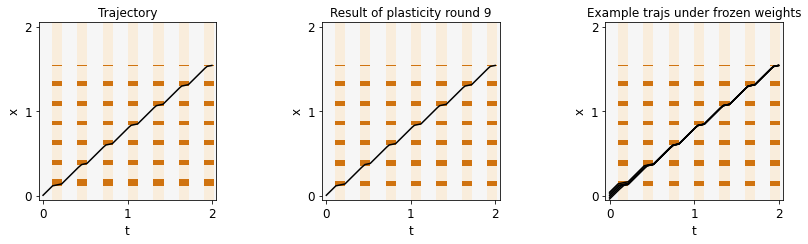

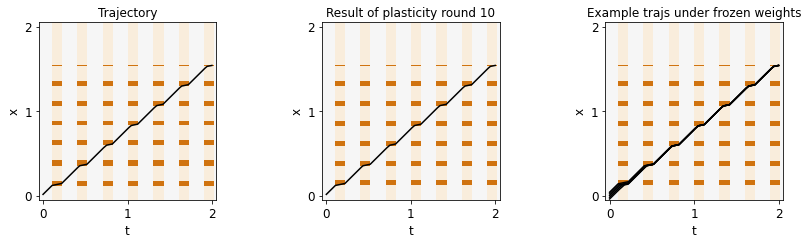

In [5]:
NROUND = 10
# X_0S = np.array([-.04, -.03, -.02, -.01, 0, .01, .02])
X_0_NOISE = .03
W_SCALE = 0.3

# x_0s = np.array([-.02, 0, .02])
x_0s = np.array([-.04, -.02, 0, .02, .04])
# x_0s = np.linspace(0, .3, 6)

t = np.arange(0, 2., DT)

w = W_SMALL*np.ones(len(RX))

for cround in range(NROUND):
    
    # x, u, v = smlt(0., t, u_fn, w)
    x, u, v = smlt(np.random.randn()*X_0_NOISE, t, u_fn, w)
    w_new, atvy, mx = update_w(w, t, x, u, delta=.04)

    fig, axs = plt.subplots(1, 3, figsize=(12, 3.5), tight_layout=True)
    plot_trj(axs[0], u_fn, w, t, [x], cscale=.25/W_SCALE)
    set_plot(axs[0], x_lim=(-0.05, 2.05), y_lim=(-.05, 2.05), title='Trajectory')

    plot_trj(axs[1], u_fn, w_new, t, [x], cscale=.25/W_SCALE)
    set_plot(axs[1], x_lim=(-0.05, 2.05), y_lim=(-.05, 2.05), title=f'Result of plasticity round {cround+1}')

    xs = [smlt(x_0, t, u_fn, w_new)[0] for x_0 in x_0s]
    plot_trj(axs[2], u_fn, w_new, t, xs, cscale=.25/W_SCALE)
    set_plot(axs[2], x_lim=(-0.05, 2.05), y_lim=(-.05, 2.05), title='Example trajs under frozen weights')
    
    w = w_new

In [6]:
def get_contr(t, xs, per_t):
    """Compute the median nearest-neighbor distance of the trajectories
    at every period. This will decrease for sufficiently dense x_0 if the
    system has a timing attractor."""
    
    med_nn_dists = []
    
    iper_t = int(round(per_t/DT))
    its = np.arange(0, len(t), iper_t)
    
    for it in its:
        xs_ = xs[:, it]
        nn_dists = np.abs(np.diff(xs_))
        med_nn_dists.append(np.median(nn_dists))
    
    return np.array(med_nn_dists)

In [7]:
med_nn_dists = get_contr(t, np.array(xs), PER_T)

In [12]:
med_nn_dists

array([0.02  , 0.0046, 0.0011, 0.0004, 0.0004, 0.0004, 0.0003])